In [207]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [208]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

In [209]:
data_covid = pd.read_csv('covid_19_clean_complete.csv')
data_covid["Date"] = pd.to_datetime(data_covid["Date"],infer_datetime_format = True)
data_covid.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
0,NaN,Afghanistan,33.0000,65.0000,2020-01-22,0,0,0
1,NaN,Albania,41.1533,20.1683,2020-01-22,0,0,0
2,NaN,Algeria,28.0339,1.6596,2020-01-22,0,0,0
3,NaN,Andorra,42.5063,1.5218,2020-01-22,0,0,0
4,NaN,Angola,-11.2027,17.8739,2020-01-22,0,0,0


In [210]:
GT_data_covid = data_covid[(data_covid["Country/Region"]=="Guatemala" ) & (data_covid["Confirmed"] > 0)]
GT_data_covid = GT_data_covid[['Date','Confirmed']].copy()
GT_data_covid = GT_data_covid.reset_index(drop=True)
GT_data_covid.head()

,Date,Confirmed
0,2020-03-14,1
1,2020-03-15,1
2,2020-03-16,2
3,2020-03-17,6
4,2020-03-18,6


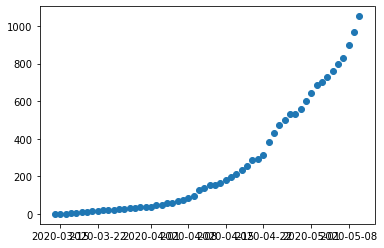

In [211]:
plt.scatter(x=GT_data_covid["Date"], y=GT_data_covid["Confirmed"])

In [212]:
GT_data_covid["log_confirmed"] = np.log(GT_data_covid["Confirmed"])
GT_data_covid.head()

,Date,Confirmed,log_confirmed
0,2020-03-14,1,0.000000
1,2020-03-15,1,0.000000
2,2020-03-16,2,0.693147
3,2020-03-17,6,1.791759
4,2020-03-18,6,1.791759


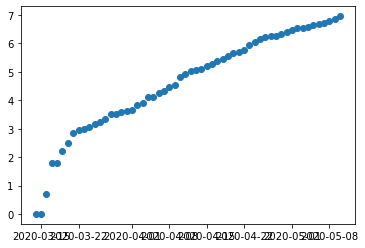

In [213]:
plt.scatter(x=GT_data_covid["Date"], y=GT_data_covid["log_confirmed"])

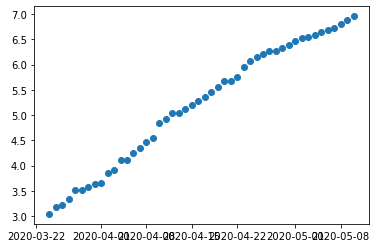

In [214]:
GT_data_covid = GT_data_covid[(GT_data_covid["Date"] >= '2020-03-24')]
plt.scatter(x=GT_data_covid["Date"], y=GT_data_covid["log_confirmed"])

In [215]:
def error(y, y_pred):
    return 1/2*tf.reduce_mean(tf.math.square(y - y_pred))

In [216]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    parametros_entrenables = tf.get_variable(name="Parametros_Entrenables", dtype=tf.float32, #shape=[2,1], 
                                initializer=[[0.0],[0.0]])
    
    tensor_x = tf.placeholder(dtype=tf.float32,name="X")
    tensor_y = tf.placeholder(dtype=tf.float32,name="Y")
    tensor_lr = tf.placeholder(dtype=tf.float32,name="LR")

    with tf.name_scope("Matriz_X"):
        matriz_x = tf.stack([tensor_x, tf.ones(tf.shape(tensor_x))],1)
    with tf.name_scope("Model"):
        y_pred = tf.linalg.matmul(matriz_x,parametros_entrenables)
    with tf.name_scope("MSE"):
        MSE = error(tensor_y, y_pred)
        cost_summary = tf.summary.scalar("cost",MSE)
    with tf.name_scope("Gradient_Descent"):
        gradientes = tf.gradients(MSE,parametros_entrenables, name="Gradients")
        actualizacion_parametros = tf.assign(parametros_entrenables,parametros_entrenables - tensor_lr*gradientes[0]
        ,name="Parameters_Update")
#    with tf.train.MonitoredSession() as session:
#        feed_dict = {tensor_x:data_x, tensor_y:data_y, tensor_lr:lr}
#        print(session.run([gradientes,actualizacion_parametros],feed_dict=feed_dict))

In [217]:
def TrainingModel(dataX, dataY, epochs, batch_size, lr):
    total_iteraciones = int(dataX.size/batch_size)

    tf.reset_default_graph()
    with tf.Session(graph=g) as session:
        writer = tf.summary.FileWriter('./graphs/Tarea1-LinearRegression_epochs='+str(epochs)+'_batchsize='+str(batch_size)+'_lr='+str(lr), session.graph)
        init = tf.global_variables_initializer()
        session.run(init)
        for epoch in range(epochs):
            for i in range(total_iteraciones):
                muestra_inicio = i * batch_size
                muestra_fin = muestra_inicio + batch_size
                x = np.array(data_x[muestra_inicio:muestra_fin])
                y = np.array(data_y[muestra_inicio:muestra_fin])
                feed_dict = {tensor_x:x, tensor_y:y, tensor_lr: lr}
                parametros = session.run([actualizacion_parametros],feed_dict=feed_dict)
                #print("Epoch {} iteracion {} m={} b={}".format(epoch,i,parametros[0][0],parametros[0][1]))
            feed_dict = {tensor_x:data_x, tensor_y:data_y}
            predicciones, c, best_params = session.run([y_pred,cost_summary, parametros_entrenables],feed_dict=feed_dict)
            writer.add_summary(c, epoch)
        return(best_params)

In [218]:
data_x = np.array(GT_data_covid["Date"].index.values)
data_y = np.array(GT_data_covid["log_confirmed"])

epochs = 5000
batch_size = 15
lr = 0.001

best_m_b = TrainingModel(data_x,data_y, epochs, batch_size,lr)


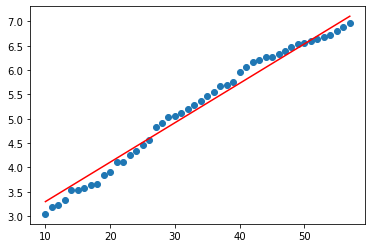

In [219]:
plt.scatter(x=GT_data_covid["Date"].index.values, y=GT_data_covid["log_confirmed"])
plt.plot(GT_data_covid["Date"].index.values, GT_data_covid["Date"].index.values*best_m_b[0]+best_m_b[1], color='red')

In [220]:
# 2020-05-30 = 57 + 20 = 77
GT_data_covid

,Date,Confirmed,log_confirmed
10,2020-03-24,21,3.044522
11,2020-03-25,24,3.178054
12,2020-03-26,25,3.218876
13,2020-03-27,28,3.332205
14,2020-03-28,34,3.526361
15,2020-03-29,34,3.526361
16,2020-03-30,36,3.583519
17,2020-03-31,38,3.637586
18,2020-04-01,39,3.663562
19,2020-04-02,47,3.850148
